<div style="border-width:5px; border-style:double; border-radius:20px; border-top-color:blue; border-bottom-color:red; padding:15px; box-shhadow:3px 3px 10px rgba(0,0,0,0.3);background:linear-gradient(to right, darkblue, red); border-right-color:blue; border-left-color:red"> 
<h1 style="text-align:center; font-weight:bold; font-size: 34px; color:white"> Haiti’s Food Market Inequality: Predicting Price Dynamics Across Departments</h1>
</div>

### Installing required libraries

In [1]:
%pip install pandas numpy seaborn matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV

#### Click the link to have access to the cleaned dataset

https://github.com/carl3991/Hands-On-Haiti

In [3]:
import os

# Showing the uploaded csv file's working directory
print(os.getcwd())

# Lists all files in the directory to make sure the file is visible
print('The list of file in my directory:\n', os.listdir())  

/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/My Projects/Haiti
The list of file in my directory:
 ['.ipynb_checkpoints', 'draft_projects.ipynb', 'wfp_food_prices_hti.csv', 'FoodEconomy_modeling.ipynb', 'Folium_LauchSite.ipynb', 'ht.json', 'FoodEconomy_folium.ipynb', 'cleaned_food_prices.csv', 'FoodEconomy_EDA.ipynb']


In [4]:
# Loading the cleaned csv file from the previous EDA analysi
haiti_df = pd.read_csv("/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/My Projects/Haiti/cleaned_food_prices.csv")

# Showing top 5 rows
print(haiti_df.head())

         date  Department      City    market  latitude  longitude  \
0  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
1  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
2  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
3  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   
4  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   

            food_type               commodity     unit  usdprice  
0  cereals and tubers      Maize meal (local)  Marmite    0.4554  
1  cereals and tubers           Rice (tchako)  Marmite    0.7135  
2  cereals and tubers  Wheat flour (imported)  Marmite    0.4554  
3  cereals and tubers   Maize meal (imported)    Pound    0.0999  
4  cereals and tubers      Maize meal (local)  Marmite    0.2733  


In [5]:
# Checking the data types
print(haiti_df.dtypes)

date           object
Department     object
City           object
market         object
latitude      float64
longitude     float64
food_type      object
commodity      object
unit           object
usdprice      float64
dtype: object


In [6]:
# Converting date column to datetime data type
haiti_df['date'] = pd.to_datetime(haiti_df['date'])

# Converting categorical features to catogory
cat_features = ['Department', 'City', 'market', 'food_type', 'commodity', 'unit']
haiti_df[cat_features] = haiti_df[cat_features].astype('category')

print(haiti_df.dtypes)

date          datetime64[ns]
Department          category
City                category
market              category
latitude             float64
longitude            float64
food_type           category
commodity           category
unit                category
usdprice             float64
dtype: object


In [7]:
haiti_df = pd.read_csv("cleaned_food_prices.csv")
haiti_df['date'] = pd.to_datetime(haiti_df['date'])


All good now!

<hr style="background:linear-gradient(to right,blue,red)"> </hr>

# Feature Engineering 

Let's create a month variable to detect seasonality.

In [8]:
# Creating month feature 
haiti_df['month'] = haiti_df['date'].dt.month
haiti_df.head()

,date,Department,City,market,latitude,longitude,food_type,commodity,unit,usdprice,month
0,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal (local),Marmite,0.4554,1
1,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice (tchako),Marmite,0.7135,1
2,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour (imported),Marmite,0.4554,1
3,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (imported),Pound,0.0999,1
4,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (local),Marmite,0.2733,1


In [10]:
# Showing unique elements in month feature
print(haiti_df['month'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]


#### Reasons for dropping the columns below:

1. To avoid **multicollinearity**, I will drop the `City` column. Each city belongs to one department in Haiti, meaning that the `Department` column is a function of the `City` column.
   
2. I will also drop the `food_types` column because commodity does a better job at describing the food economy (more relevant).
   
3. Finally, I'm dropping the `unit` column because it doesn't give a consistent measure across products. Each commodity tends to come in just one unit (like oil by gallon or flour by marmite), so it doesn't add new information. To keep it, I’d need to convert all prices to the same base unit — like price per pound — which is outside this project’s scope.

<hr style="background:linear-gradient(to right,blue,red)"> </hr>

# Model development

 Now, let's select our predictors for modeling and encode Department, commodity, and market features.

In [11]:
# One-hot encode categorical features
features = ['commodity', 'Department', 'market']
X = pd.get_dummies(haiti_df[features], drop_first=True)
y = haiti_df['usdprice'] 

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print("RMSE:", round(rmse, 5))
print("R^2 Score:", round(r2, 5))


RMSE: 1.89676
R^2 Score: 0.45347


-  **R^2 = 0.45347** implies that the model, with commodity, region, and market predictors, explains about 45% of the variance in price. However, some seasonal or supply shocks haven’t been captured yet.

- **RMSE = 1.89676** implies that the predictions are, on average, off by about $1.90. 

##### Let's try including the month feature to improve the model's performance.

Let's transform month feature to category

In [12]:
haiti_df['month'] = haiti_df['date'].dt.month
haiti_df['month'] = haiti_df['month'].astype('category') 


In [13]:
haiti_df.head()

,date,Department,City,market,latitude,longitude,food_type,commodity,unit,usdprice,month
0,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal (local),Marmite,0.4554,1
1,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice (tchako),Marmite,0.7135,1
2,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour (imported),Marmite,0.4554,1
3,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (imported),Pound,0.0999,1
4,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (local),Marmite,0.2733,1


In [14]:
haiti_df.dtypes

date          datetime64[ns]
Department            object
City                  object
market                object
latitude             float64
longitude            float64
food_type             object
commodity             object
unit                  object
usdprice             float64
month               category
dtype: object

In [15]:
# Refitting and re-evaluating with month feature
features2 = ['commodity', 'Department', 'market', 'month']
X = pd.get_dummies(haiti_df[features2], drop_first=True)
y = haiti_df['usdprice']

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print("RMSE:", round(rmse, 5))
print("R^2 Score:", round(r2, 5))



RMSE: 1.89894
R^2 Score: 0.45222


These results suggest that the price variation isn't well explained by month differences.

### Log- Transformation on target variable

I will apply the logarithmic transformation on the price feature to make the model less sensitive to high-price outliers.

In [16]:
# Applying log transformation to target
haiti_df['log_usdprice'] = np.log1p(haiti_df['usdprice'])

# with transformed y
features2 = ['commodity', 'Department', 'market']
X = pd.get_dummies(haiti_df[features2], drop_first = True)
y_log = haiti_df['log_usdprice']

#splitting dataset
X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_log_train)

# Predict and evaluate
y_log_pred = model.predict(X_test)
rmse = mean_squared_error(y_log_test, y_log_pred)**0.5
r2 = r2_score(y_log_test, y_log_pred)

print("RMSE:", round(rmse, 5))
print("R^2 Score:", round(r2, 5))

RMSE: 0.46718
R^2 Score: 0.47948


### Model Performance Comparison

- RMSE dropped from **1.90** to **0.47**, indicating reduced prediction error.
- R^2 improved from **0.45** to **0.48**, showing the model explains more variance in price.
- Log transformation helped reduced the influence of high-cost commodities like oil or imported rice.


<hr style="background:linear-gradient(to right,blue,red)"> </hr>

# Residual Analysis

#### With log transformation.

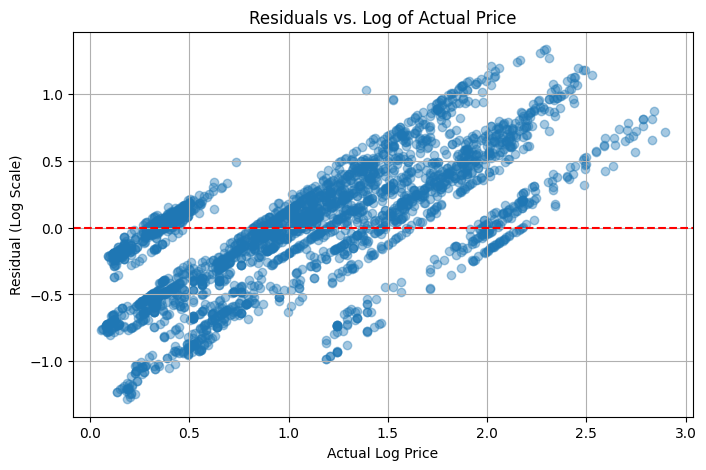

In [19]:
# Calculating residuals
residuals_log = y_log_test - y_log_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_log_test, residuals_log,alpha=0.4)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Log Price")
plt.ylabel("Residual (Log Scale)")
plt.title("Residuals vs. Log of Actual Price")
plt.grid(True)
plt.show()


The residuals are:

- `Symmetrically distributed` around the red zero line. Sign of a stable model.

- `Randomly scattered`. This means the model isn't systematically overpredicting or underpredicting at specific price levels.

- `Homoskedastic` (no major variances across the price range).


#### Residual Histogram

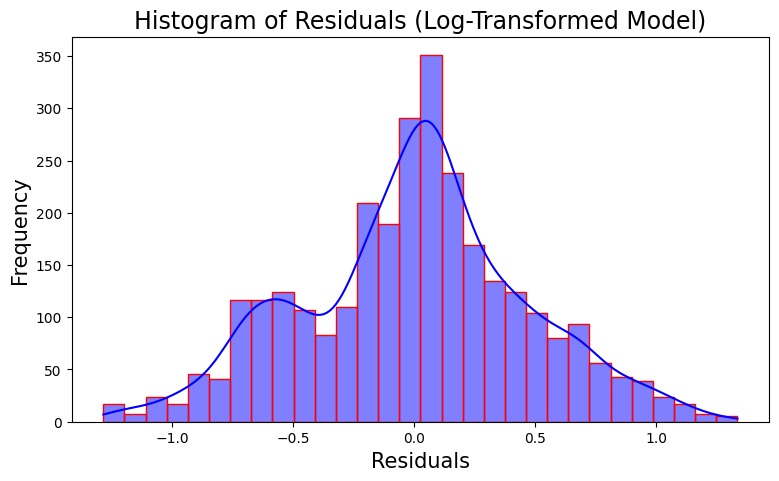

In [20]:
# Creating a histogram for residuals with Kernel Density Estimate (KDE)
plt.figure(figsize=(9, 5))
sns.histplot(residuals_log, bins=30, kde=True, color='blue', edgecolor='red')

plt.title("Histogram of Residuals (Log-Transformed Model)", fontsize=17)
plt.xlabel("Residuals", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()


-  The model is well-calibrated overall. No big spikes detected or long tails detected.

- The KDE follows a smooth curve, and points to an approximate normal distribution.

 #### Thus, the model can predictions close to true values.

<div style="border: double black; background: linear-gradient(to right, white, lightblue);">
<h1 style="text-align:center" > Summary </h1>
<p style="text-align:center"> A log-transformed Multiple Linear Regression model emerged as the most effective and interpretable approach for capturing price dynamics across Haiti’s food markets. It reduced RMSE from $1.90 to $0.47 and improved R^2 from 0.45 to 0.48, showing stronger predictive precision. Finally, the residual analysis confirmed model stability, with symmetric error distribution and consistent variance across price ranges. </p>
<hr style=" background: linear-gradient(to right, white, pink)"> </hr>
<h3 style="text-align: center;"> Presented by:
<a href="https://www.linkedin.com/in/carllegros/" target="_blank" style="color:blue"> Carl Legros</a>
</h3>
</div>